In [3]:
#Data Handling
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.image as mpimg
import os
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.applications import ResNet101V2

#TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as lyrs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

#Global Variables
root="./tcmimage"
IMG_SIZE=224

In [2]:
#os.getcwd()
#!unzip './tcmimage.zip' -d './'
#!rm -rf tcmimage.zip

In [4]:
#View Random Image
def view_random_image(root_path,folder,class_folder):
    path=root_path+'/'+folder+'/'+class_folder
    rand=random.choice(os.listdir(path))
    random_image=mpimg.imread(path+'/'+rand)
    plt.imshow(random_image)
    plt.title("File Name: " + rand)

#Pre-processing the Image
def pre_process_image(path, image_shape=224, channels=3, norm_factor=255.):
    '''Pre-Processing the Image before sending it to the model'''
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=channels)
    img = tf.image.resize(img, size = (image_shape, image_shape))
    img = tf.expand_dims(img, axis=0)
    img = img/norm_factor
    return img

#Testing Image Classification Model
def random_tester(root_path, classes, model, class_type="binary"):
    '''Random Class Folder Selection'''
    path=root_path
    class_folder=random.choice(os.listdir(path))

    '''Random File Selection'''
    folder_path=path+'/'+class_folder+'/'
    rand=random.choice(os.listdir(folder_path))
    file_path=folder_path+'/'+rand
    random_image=mpimg.imread(file_path)

    '''Prediction'''
    predicted_value=model.predict(pre_process_image(file_path))
    if(class_type=="binary"):
        predicted_label=classes[custom_rounder(predicted_value)]
    else:
        index=tf.math.round(predicted_value).numpy()
        index=np.argmax(index)
        predicted_label=classes[index]

    '''Visualize'''
    plt.imshow(random_image)
    plt.title("Prediction:" + predicted_label +"\n" +"True class: "+ class_folder)
    plt.show()

#Plot Loss and Accuracy curve for the given Model
def loss_curve_plot(df):
    """ Dataframe (df) is history of the fit of the NN model
    The df consists of train and validation fit data
    """
    history = df.history
    val_accuracy = history["val_accuracy"]
    val_loss = history["val_loss"]
    train_accuracy = history["accuracy"]
    train_loss = history["loss"]

    """Accuracy Plot"""
    plt.plot(train_accuracy, label="Train Accuracy")
    plt.plot(val_accuracy, label="Validation Accuracy")
    plt.title("Accuracy Curves")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

    """Loss Plot"""
    plt.plot(train_loss, label="Train loss")
    plt.plot(val_loss, label="Validation loss")
    plt.title("Loss Curves")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

#Confusion Matrix for Classification
def confusion_matrix_plot(y_true, y_pred, figsize=(30,30)):
    """"Confusion Matrix for true values and predicted values"""
    cm = metrics.confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)
    plt.figure(figsize = figsize)
    sns.heatmap(cm, annot=True, cmap="crest")

#Supervised Learning Meterics
def supervised_metrics(y_true, y_pred):
    """Meterics for a Supervised Learning model:"""
    print("Accuracy : {} %".format(accuracy_score(y_true, y_pred)*100))
    print("F1 Score : {}".format(f1_score(y_true, y_pred, average='weighted')))
    print("Recall : {}".format(recall_score(y_true, y_pred, average='weighted')))
    print("Precision : {}".format(precision_score(y_true, y_pred, average='weighted')))

In [5]:
data_augmentation = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

train_datagen = data_augmentation.flow_from_directory(
    directory=root,
    batch_size=32,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode="categorical",
    subset="training",
    seed=42,
)

test_datagen = data_augmentation.flow_from_directory(
    directory=root,
    batch_size=32,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode="categorical",
    subset="validation",
    shuffle=False,
    seed=42,
)

Found 9758 images belonging to 40 classes.
Found 2419 images belonging to 40 classes.


In [6]:
#Import MobileNetV2 Model
model_base = ResNet101V2(
    input_shape=(224,224,3),
    include_top=False,
)
model_base.trainable = True

for layers in model_base.layers[:-30]:
    layers.trainable=False

#Transfer Learning Model
inputs=tf.keras.Input(shape=(224,224,3))
x=model_base(inputs)
x=lyrs.GlobalAveragePooling2D()(x)
x= lyrs.Dropout(0.5)(x)
outputs=lyrs.Dense(40, activation="softmax",
                     kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet101v2 (Functional)             │ (None, 7, 7, 2048)          │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 40)                  │          81,960 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,708,520 (162.92 MB)

 Trainable params: 14,525,480 (55.41 MB)

 Non-trainable params: 28,183,040 (107.51 MB)

In [ ]:
checkpointer = ModelCheckpoint('./model/tcmimage.keras',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 3)

model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

model_history=model.fit(x=train_datagen,
         steps_per_epoch=32,
         validation_data=test_datagen,
         epochs=20,
         callbacks=[checkpointer, early_stopping])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.1071 - loss: 3.7765 
Epoch 1: val_loss improved from inf to 2.50963, saving model to ./model/tcmimage.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1040s 33s/step - accuracy: 0.1104 - loss: 3.7610 - val_accuracy: 0.3642 - val_loss: 2.5096
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5556 - loss: 1.9430 
Epoch 2: val_loss improved from 2.50963 to 1.85931, saving model to ./model/tcmimage.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1034s 33s/step - accuracy: 0.5574 - loss: 1.9366 - val_accuracy: 0.5391 - val_loss: 1.8593
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6911 - loss: 1.2984 
Epoch 3: val_loss improved from 1.85931 to 1.52580, saving model to ./model/tcmimage.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1028s 33s/step - accuracy: 0.6923 - loss: 1.2937 - val_accuracy: 0.6337 - val_loss: 1.5258
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8307 - loss: 0.7962 
Epoch 4: val_loss improved from 1.52580 to 1.235

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 10: val_loss improved from 0.85487 to 0.84936, saving model to ./model/tcmimage.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 853s 27s/step - accuracy: 0.9120 - loss: 0.4091 - val_accuracy: 0.7850 - val_loss: 0.8494
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9290 - loss: 0.3384 
Epoch 11: val_loss improved from 0.84936 to 0.79145, saving model to ./model/tcmimage.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1072s 32s/step - accuracy: 0.9292 - loss: 0.3378 - val_accuracy: 0.7995 - val_loss: 0.7914
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9327 - loss: 0.3080 
Epoch 12: val_loss improved from 0.79145 to 0.74980, saving model to ./model/tcmimage.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1018s 32s/step - accuracy: 0.9327 - loss: 0.3085 - val_accuracy: 0.8107 - val_loss: 0.7498
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9344 - loss: 0.2878 
Epoch 13: val_loss improved from 0.74980 to 0.71860, saving model to ./model/tcmimage.keras
32/32 ━━━━━━━━━━━━━━

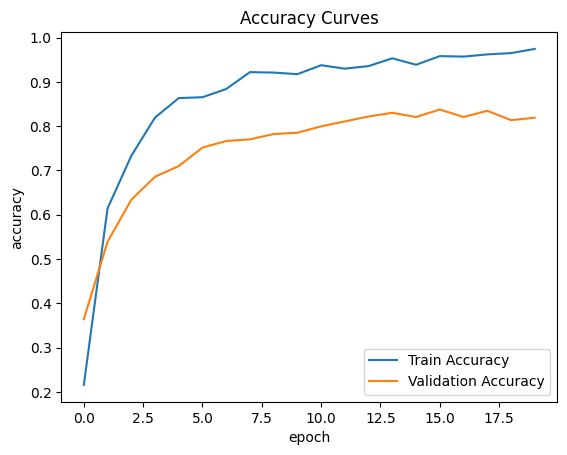

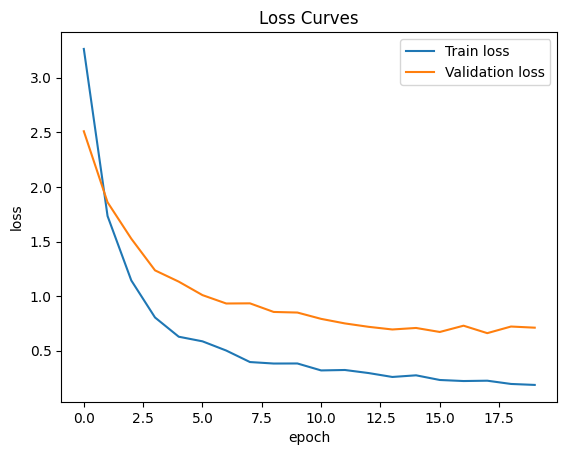

In [ ]:
 loss_curve_plot(model_history)

In [ ]:
# 获取真实标签
labels = test_datagen.classes

# 加载训练好的模型
model = tf.keras.models.load_model("./tcmimage.keras")

# 使用模型进行预测，y_pred的维度应为 (num_samples, num_classes)
y_pred = model.predict(test_datagen)

# 对预测结果应用 argmax，从每个样本的概率分布中选择概率最大的类别
prediction = y_pred.argmax(axis=1)

# 调用评估函数，计算准确性、F1 分数、召回率、精确度等
supervised_metrics(labels, prediction)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


76/76 ━━━━━━━━━━━━━━━━━━━━ 702s 9s/step
Accuracy : 83.46424142207523 %
F1 Score : 0.8370669481922717
Recall : 0.8346424142207524
Precision : 0.8495360151369378


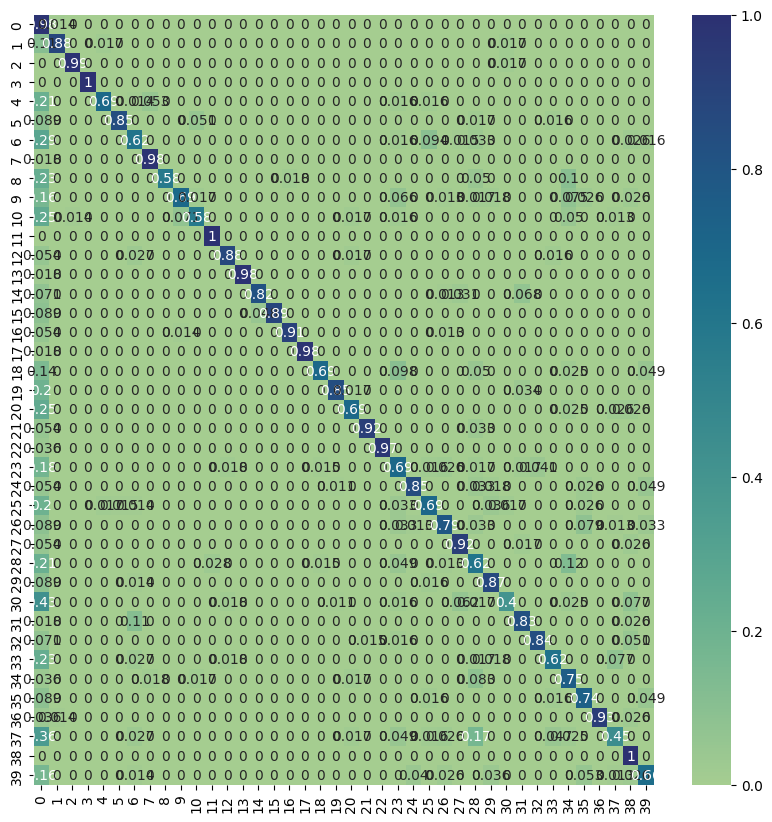

In [ ]:
confusion_matrix_plot(labels, prediction, figsize=(10,10))

In [ ]:
#模型性能未达标，继续训练
mdoel_tcm = tf.keras.models.load_model("./tcmimage.keras")
checkpointer = ModelCheckpoint('./tcmimage_new.keras',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 3)

mdoel_tcm.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

model_history=mdoel_tcm.fit(x=train_datagen,
         steps_per_epoch=32,
         validation_data=test_datagen,
         epochs=20,
         callbacks=[checkpointer, early_stopping])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9651 - loss: 0.1976 
Epoch 1: val_loss improved from inf to 0.69823, saving model to ./tcmimage_new.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1083s 34s/step - accuracy: 0.9650 - loss: 0.1980 - val_accuracy: 0.8276 - val_loss: 0.6982
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9531 - loss: 0.2234 
Epoch 2: val_loss did not improve from 0.69823
32/32 ━━━━━━━━━━━━━━━━━━━━ 1037s 33s/step - accuracy: 0.9530 - loss: 0.2240 - val_accuracy: 0.8156 - val_loss: 0.7597
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9413 - loss: 0.2546 
Epoch 3: val_loss did not improve from 0.69823
32/32 ━━━━━━━━━━━━━━━━━━━━ 1054s 34s/step - accuracy: 0.9415 - loss: 0.2541 - val_accuracy: 0.8227 - val_loss: 0.7288
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9702 - loss: 0.1853 
Epoch 4: val_loss improved from 0.69823 to 0.64686, saving model to ./tcmimage_new.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1037s 33s/step - accur